TASK - 5 

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from tree.base import DecisionTree

np.random.seed(42)
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1,
    n_clusters_per_class=2, class_sep=0.5
)
X_df = pd.DataFrame(X, columns=['Feature1', 'Feature2'])
y_series = pd.Series(y, dtype='category')

from sklearn.model_selection import train_test_split
from metrics import accuracy, precision, recall
from tree.base import DecisionTree

X_train, X_test, y_train, y_test = train_test_split(X_df, y_series, test_size=0.3, random_state=42)

tree = DecisionTree(criterion='gini_index') 
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("Accuracy: ", accuracy(y_pred, y_test))
for cls in y_test.unique():
    print(f"Precision for class {cls}: ", precision(y_pred, y_test, cls))
    print(f"Recall for class {cls}: ", recall(y_pred, y_test, cls))


#2B

class DecisionTreeWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, criterion='gini_index', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth)
        self.tree.fit(X, y)
        
        self.classes_ = y.unique()
        return self

    def predict(self, X):
        return self.tree.predict(X)

    def predict_proba(self, X):
        
        if hasattr(self.tree, 'predict_proba'):
            return self.tree.predict_proba(X)
        else:
            raise NotImplementedError("predict_proba is not implemented in the custom DecisionTree")

param_grid = {'max_depth': list(range(1, 11))}

grid_search = GridSearchCV(
    DecisionTreeWrapper(criterion='gini_index'),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_df, y_series)

print('\nQ2')
print("Best parameters (depth): ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Accuracy:  0.9666666666666667
Precision for class 1:  1.0
Recall for class 1:  0.9333333333333333
Precision for class 0:  0.9375
Recall for class 0:  1.0

Q2
Best parameters (depth):  {'max_depth': 1}
Best cross-validation score:  0.89


Custom Decision Tree Performance:
RMSE: 3.265582144219229
MAE: 2.559685959970595
? (weight <= 2818.5)
Y:     ? (acceleration <= 16.0)
    Y:         ? (displacement <= 116.0)
        Y:             ? (horsepower <= 75.5)
            Y:                 ? (model year <= 79.0)
                Y:                     Leaf: 30.560000000000002
                N:                     Leaf: 35.81111111111111
            N:                 ? (model year <= 76.0)
                Y:                     Leaf: 25.6
                N:                     Leaf: 31.077777777777776
        N:             ? (horsepower <= 96.0)
            Y:                 ? (model year <= 79.5)
                Y:                     Leaf: 25.29
                N:                     Leaf: 30.48
            N:                 ? (model year <= 74.0)
                Y:                     Leaf: 21.875
                N:                     Leaf: 25.400000000000002
    N:         ? (horsepower <= 68.5)
        Y:          

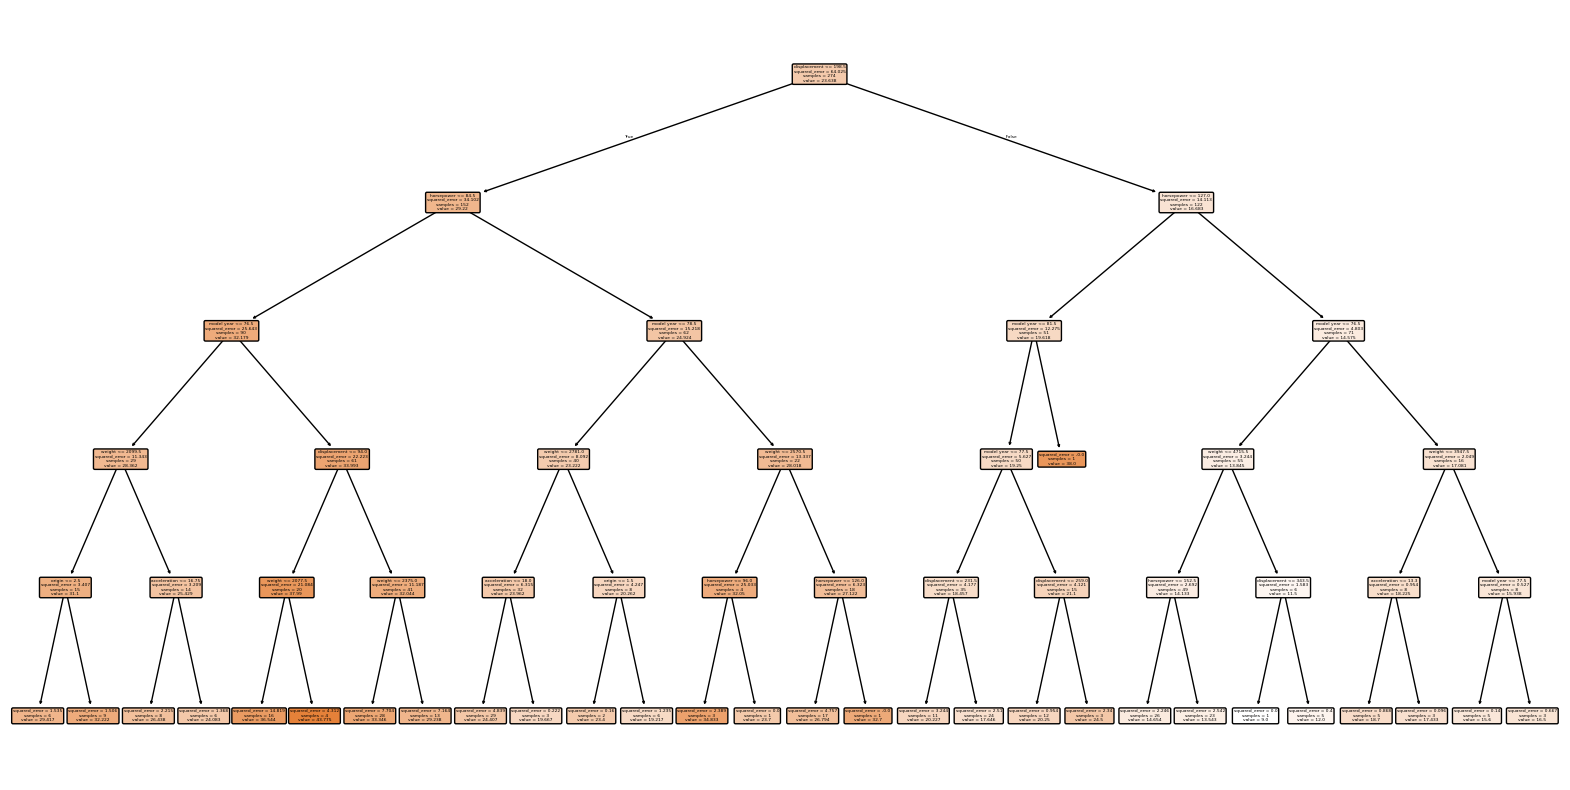

In [2]:
import pandas as pd
import numpy as np
from tree.base import DecisionTree
from metrics import rmse, mae

np.random.seed(42)

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
data = pd.read_csv(url, sep=r'\s+', header=None,
                   names=["mpg", "cylinders", "displacement", "horsepower", "weight",
                          "acceleration", "model year", "origin", "car name"])

data = data.replace("?", np.nan)
data = data.dropna()  
data = data.drop(columns=["car name"])  
data["horsepower"] = data["horsepower"].astype(float) 

X = data.drop(columns=["mpg"])
y = data["mpg"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree = DecisionTree(criterion="information_gain", max_depth=5)
tree.fit(X_train, y_train)

y_hat = tree.predict(X_test)

print("Custom Decision Tree Performance:")
print("RMSE:", rmse(y_hat, y_test))
print("MAE:", mae(y_hat, y_test))

tree.plot()



from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

sklearn_tree = DecisionTreeRegressor(criterion="squared_error", max_depth=5, random_state=42)
sklearn_tree.fit(X_train, y_train)

y_hat_sklearn = sklearn_tree.predict(X_test)

print("\nscikit-learn Decision Tree Performance:")
print("RMSE:", root_mean_squared_error(y_test, y_hat_sklearn))  # RMSE
print("MAE:", mean_absolute_error(y_test, y_hat_sklearn))

import matplotlib.pyplot as plt
from sklearn import tree as sk_tree

plt.figure(figsize=(20, 10))
sk_tree.plot_tree(sklearn_tree, feature_names=X.columns, filled=True, rounded=True)
plt.show()



Running for case: Discrete Input, Discrete Output


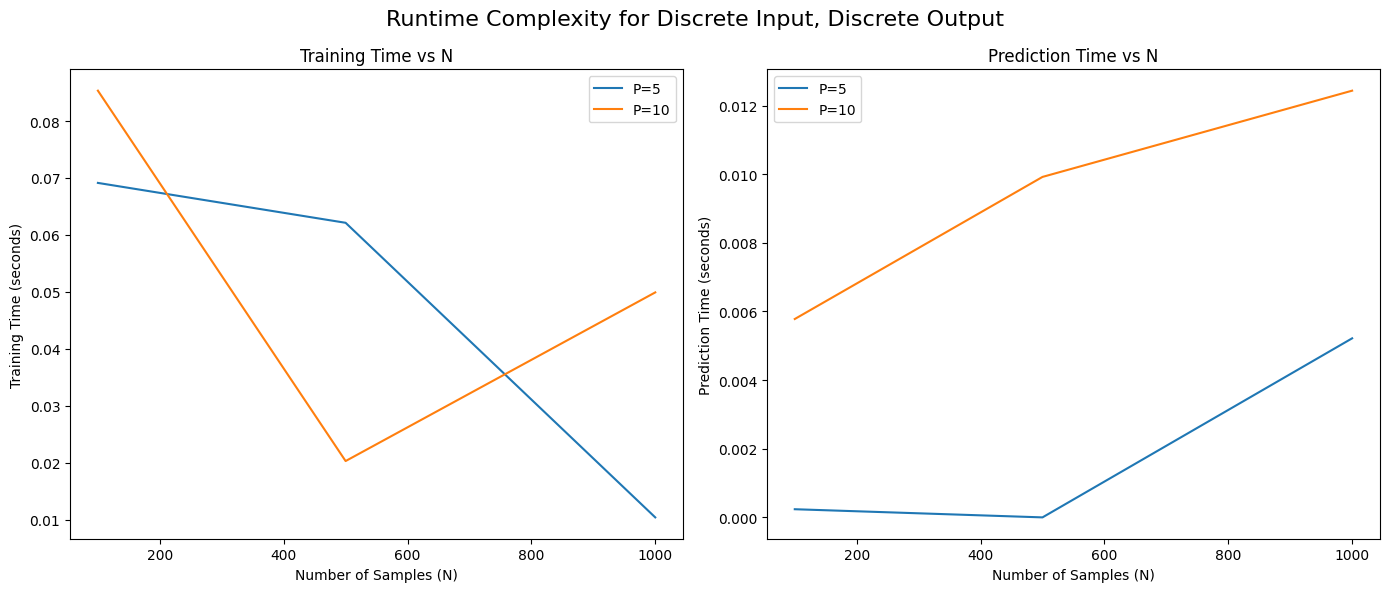

Running for case: Discrete Input, Real Output


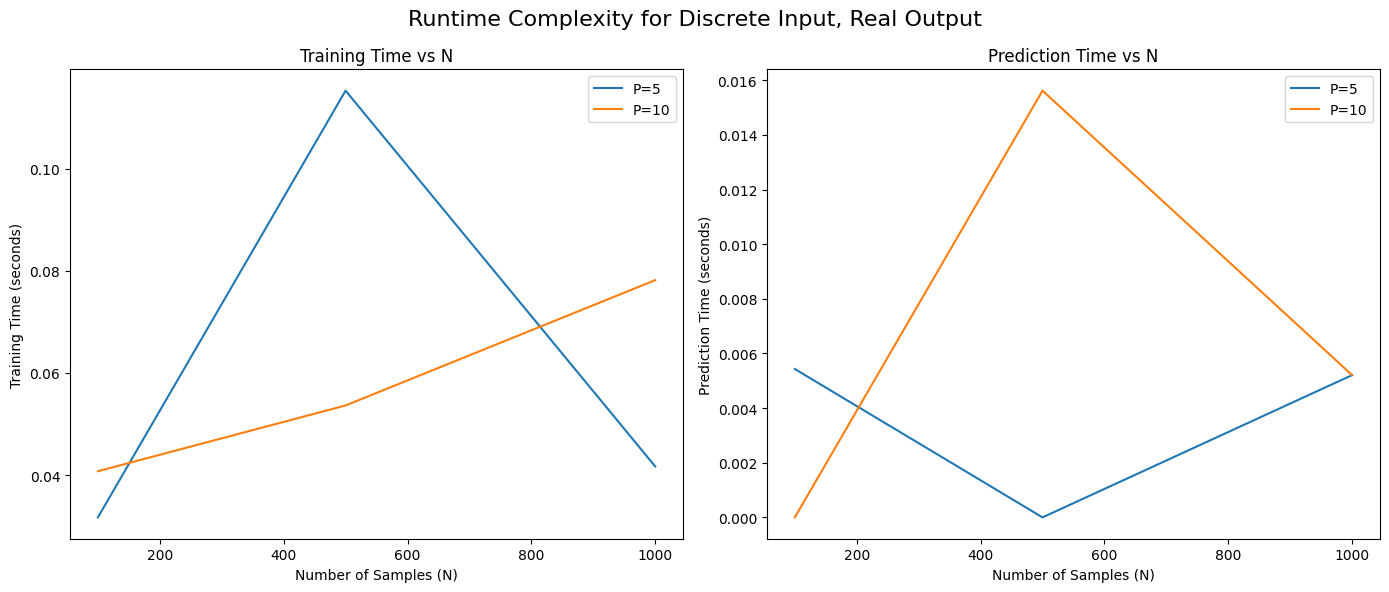

Running for case: Real Input, Discrete Output


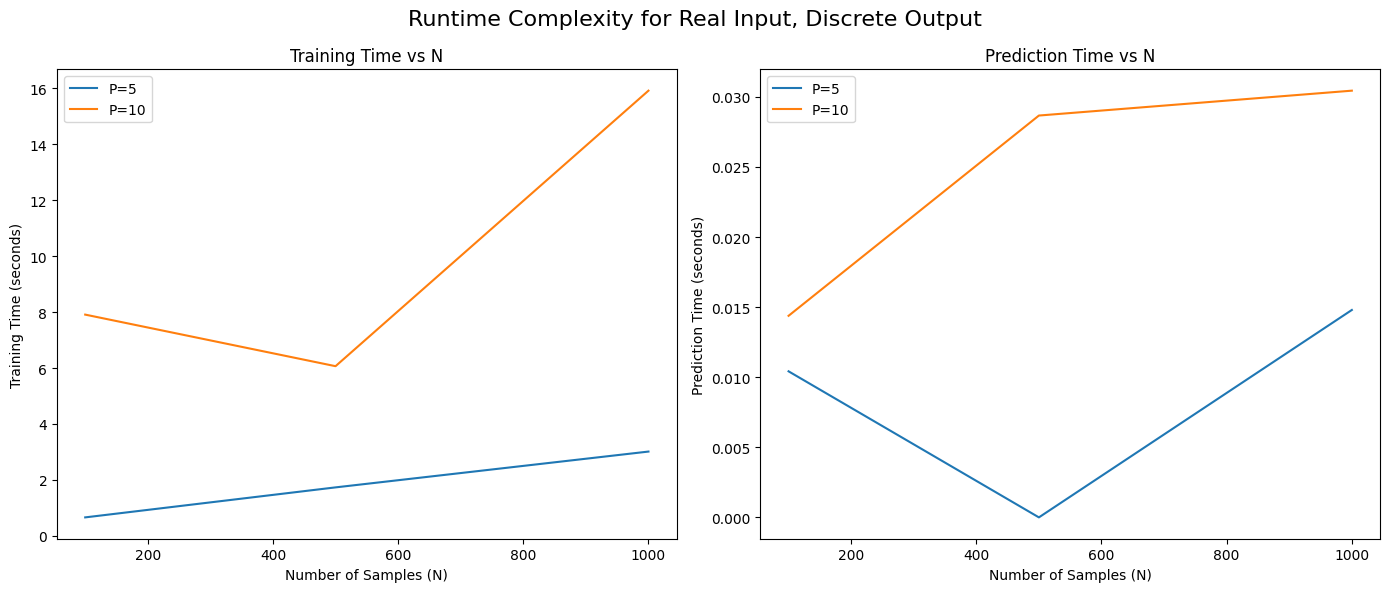

Running for case: Real Input, Real Output


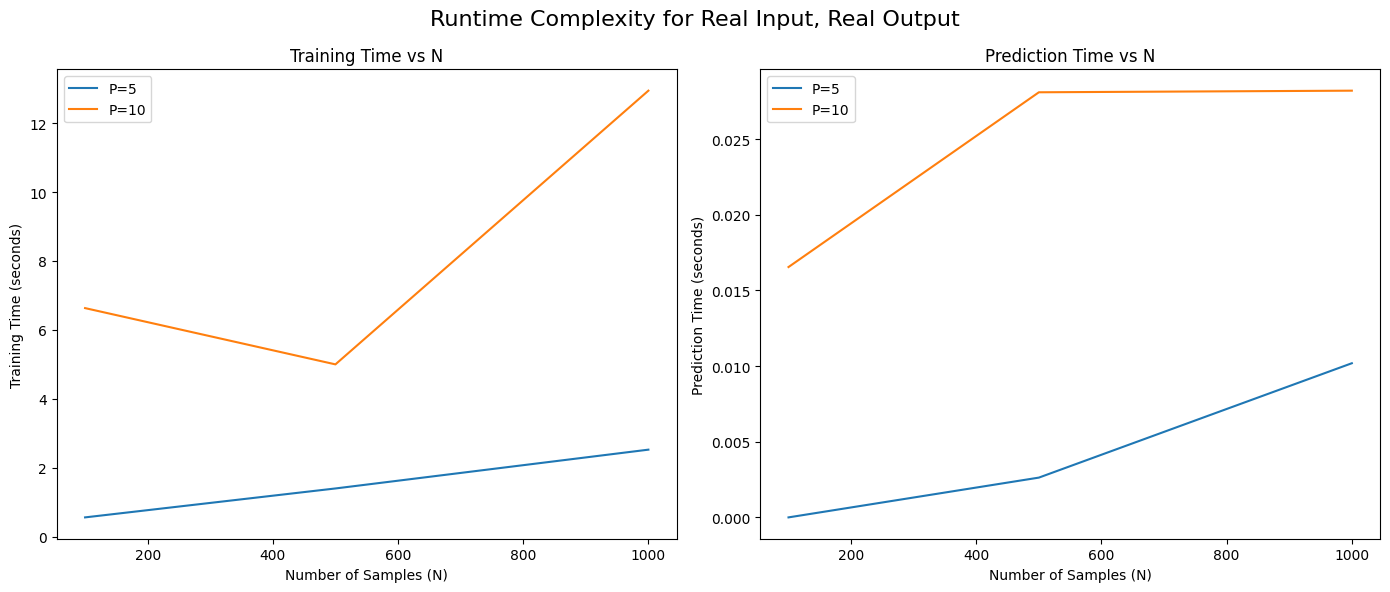

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tree.base import DecisionTree
from metrics import *

np.random.seed(42)
num_average_time = 3 

def generate_data(N, P, data_type='binary', output_type='discrete'):
    if data_type == 'binary':
        X = pd.DataFrame(np.random.randint(2, size=(N, P)), columns=[f'feature_{i}' for i in range(P)])
    else:
        X = pd.DataFrame(np.random.randn(N, P), columns=[f'feature_{i}' for i in range(P)])

    if output_type == 'discrete':
        y = pd.Series(np.random.randint(2, size=N), dtype='category')
    else:
        y = pd.Series(np.random.randn(N))

    return X, y

def measure_runtime(N_values, P_values, data_type, output_type):
    avg_train_times = []
    avg_predict_times = []

    for N in N_values:
        for P in P_values:
            train_times = []
            predict_times = []

            for _ in range(num_average_time):
                
                X, y = generate_data(N, P, data_type=data_type, output_type=output_type)
                tree = DecisionTree(criterion="information_gain", max_depth=5)

                start_time = time.time()
                tree.fit(X, y)
                train_times.append(time.time() - start_time)

                start_time = time.time()
                tree.predict(X)
                predict_times.append(time.time() - start_time)

            avg_train_times.append(np.mean(train_times))
            avg_predict_times.append(np.mean(predict_times))

    return avg_train_times, avg_predict_times

def plot_results(N_values, P_values, train_times, predict_times, case_description):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Runtime Complexity for {case_description}", fontsize=16)

    ax1.set_title("Training Time vs N")
    for P in P_values:
        ax1.plot(N_values, train_times[:len(N_values)], label=f'P={P}')
        train_times = train_times[len(N_values):]  
    ax1.set_xlabel("Number of Samples (N)")
    ax1.set_ylabel("Training Time (seconds)")
    ax1.legend()

    ax2.set_title("Prediction Time vs N")
    for P in P_values:
        ax2.plot(N_values, predict_times[:len(N_values)], label=f'P={P}')
        predict_times = predict_times[len(N_values):]  
    ax2.set_xlabel("Number of Samples (N)")
    ax2.set_ylabel("Prediction Time (seconds)")
    ax2.legend()

    plt.tight_layout()
    plt.show()

N_values = [100, 500, 1000] 
P_values = [5, 10]  

cases = [
    ('binary', 'discrete', "Discrete Input, Discrete Output"),
    ('binary', 'real', "Discrete Input, Real Output"),
    ('real', 'discrete', "Real Input, Discrete Output"),
    ('real', 'real', "Real Input, Real Output")
]

for data_type, output_type, description in cases:
    print(f"Running for case: {description}")
    avg_train_times, avg_predict_times = measure_runtime(N_values, P_values, data_type, output_type)
    plot_results(N_values, P_values, avg_train_times, avg_predict_times, description)
